In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
import torchaudio

from plotly_resampler import FigureResampler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

sys.path.append("..")
from GSSP_utils.path_conf import (
    loc_data_dir,
    speech_data_session_dir,
    interim_speech_data_dir,
)
from GSSP_utils.data_filtering import get_valid_audio_mask

from IPython.display import Audio, display

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)
sns.set_context("talk")
sns.set_style("whitegrid")  

# https://pytorch.org/audio/stable/backend.html#module-torchaudio.backend
torchaudio.get_audio_backend()

from speechbrain.pretrained import VAD
import torch


torchvision is not available - cannot save figures


The aim of this **playground notebook** is to investigate the speechbrain VAD model

In [2]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))

# load the model
VAD_model = VAD.from_hparams(
    source="speechbrain/vad-crdnn-libriparty", savedir=".vad_model"
)


## Speechbrain VAD model

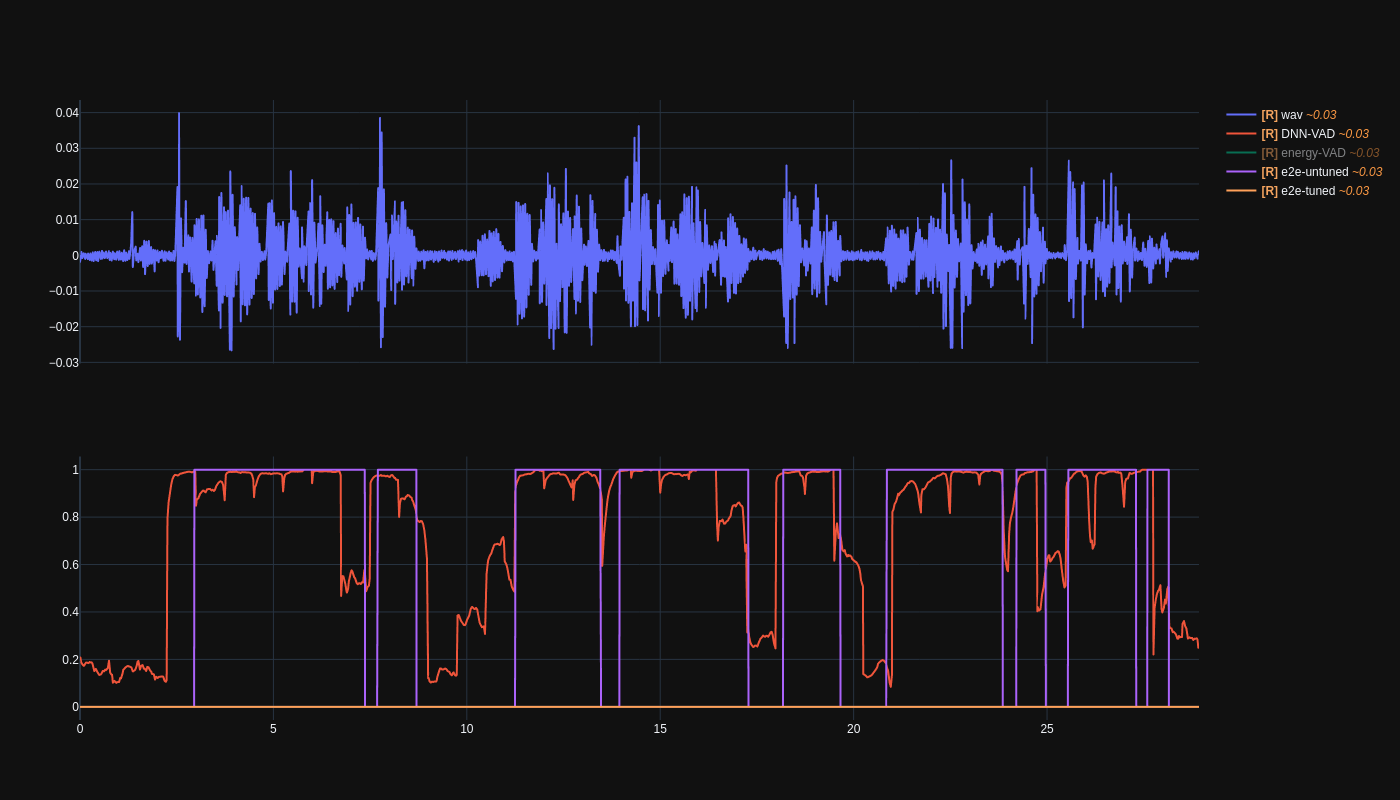

In [3]:
# Select a random row and get the corresponding wav path
row = df_session.iloc[np.random.randint(0, len(df_session))]
wav_path: Path = list(
    (interim_speech_data_dir / "full_dur_16khz").glob(
        f"*{row.ID}/{row.DB}/{row.pic_name}__{row.time_str}.wav"
    )
)[0]

# load the wav file and resample to 16kHz
arr, fs = torchaudio.load(wav_path)
arr_16khz = arr

# Temporarly save the wav file to make it compatible with the speechbrain VAD
torchaudio.save("arr_16khz.wav", arr_16khz, sample_rate=16_000)

# Apply the speechbrain VAD
speech_prob_wav = VAD_model.get_speech_prob_file(
    audio_file="arr_16khz.wav", large_chunk_size=15, small_chunk_size=0.75
)


speech_prob_energy = VAD_model.upsample_boundaries(
    VAD_model.energy_VAD(
        "arr_16khz.wav",
        # Just use the first and last timestamp as boundaries.
        boundaries=torch.tensor([[0, arr_16khz.size()[1] / 16_000]]),
        activation_th=0.5,
        deactivation_th=0.01,
    ),
    "arr_16khz.wav",
)


e2e_boundaries_no_tuning = VAD_model.upsample_boundaries(
    VAD_model.get_speech_segments(
        audio_file=str(wav_path),
        large_chunk_size=15,
        small_chunk_size=1,
        overlap_small_chunk=True,
        apply_energy_VAD=True,
        double_check=True,
    ),
    audio_file=str(wav_path),
)

# DNN_thresh = VAD_model.apply_threshold(
#     vad_prob=speech_prob_wav,
#     activation_th=0.6,
#     deactivation_th=0.3,
# )

# DNN_boundaries = VAD_model.upsample_boundaries(
#     VAD_model.get_boundaries(DNN_thresh),
#     audio_file=str(wav_path),
# )


e2e_boundaries_tuning = VAD_model.upsample_boundaries(
    VAD_model.get_speech_segments(
        audio_file=str(wav_path),
        large_chunk_size=15,
        small_chunk_size=1,
        overlap_small_chunk=True,
        apply_energy_VAD=True,
        double_check=True,
        # neural proba activation thrsholds
        activation_th=0.65,
        deactivation_th=0.3,
        # VAD energy activation thresholds
        en_activation_th=1.6,
        en_deactivation_th=0.3,
    ),
    audio_file=str(wav_path),
)


# DNN_thresh = DNN_thresh.numpy().ravel()
# DNN_boundaries = DNN_boundaries.numpy().ravel()
e2e_boundaries_no_tuning = e2e_boundaries_no_tuning.numpy().ravel()
speech_prob_energy = speech_prob_energy.numpy().ravel()
speech_prob_wav = speech_prob_wav.numpy().ravel()

# -----------------  Visualize the results ----------------- #
fr = FigureResampler(make_subplots(rows=2, cols=1, shared_xaxes=True))
fr.add_trace(
    go.Scattergl(name="wav"),
    hf_y=arr_16khz.numpy().ravel(),
    hf_x=(np.arange(arr_16khz.size()[1]) / 16_000).astype("float32"),
    row=1,
    col=1,
)

fs_frame = 100
fr.add_trace(
    go.Scattergl(name="DNN-VAD"),
    hf_y=speech_prob_wav,
    hf_x=np.arange(len(speech_prob_wav)) / fs_frame,
    row=2,
    col=1,
)
# fr.add_trace(
#     go.Scattergl(name="DNN-VAD-boundaries"),
#     hf_y=DNN_boundaries,
#     hf_x=np.arange(len(DNN_boundaries)) / 16_000,
#     row=2,
#     col=1,
# )

fr.add_trace(
    go.Scattergl(name="energy-VAD", visible="legendonly"),
    hf_y=speech_prob_energy,
    hf_x=np.arange(len(speech_prob_energy)) / 16_000,
    row=2,
    col=1,
)

fr.add_trace(
    go.Scattergl(name="e2e-untuned"),
    hf_y=e2e_boundaries_no_tuning,
    hf_x=np.arange(len(e2e_boundaries_no_tuning)) / 16_000,
    row=2,
    col=1,
)

fr.add_trace(
    go.Scattergl(name="e2e-tuned"),
    hf_y=e2e_boundaries_tuning.numpy().ravel(),
    hf_x=np.arange(e2e_boundaries_tuning.size()[1]) / 16_000,
    row=2,
    col=1,
)

fr.update_layout(template="plotly_dark", height=800)
fr.show(renderer='png', width=1400)
# fr.show_dash(mode="inline", port=8070)


In [5]:
start, stop = 10, 20 
display(Audio(arr_16khz.numpy().ravel()[int(start * 16_000) : int(stop * 16_000)], rate=16_000))
# Save the audio file
# torchaudio.save('meuch.wav', arr_16khz[:, int(start * 16_000):int(stop * 16_000)], sample_rate=16_000)
